# Flatness v.s. Generalization (Part 2)

## 采用的模型

| Model                                                        | Parameter |
| deep model：  `Conv(16, (3x3))->Pool(2)->Conv(32, (3x3))->Conv(64, (3x3))->Conv(64, (3x3))->Pool(2)->Conv(38, (3x3))->Conv(32, (3x3))->Conv(10, (1x1))->Pool(8)` |   93990   |

> 注：上述除最后一个卷积之外，每个卷积之后 加BatchNormalization和ReLU激活函数
>
> 训练采用的参数：`optimizer=Adam(lr=1e-3， amsgrad=True), epoch=100 `

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
from argparse import Namespace
from torch import optim
from model import cross_entropy_loss, accuracy
from model import deep_cifar
from dataset import cifar_train_loader, cifar_validate_loader
from utils import eval_sensitivity, Logger
from solver import HW1Solver

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 参数设置
root = os.path.join(os.path.expanduser('~'), 'data')
config = {'batch_size': 16, 'epochs': 100, 'resume': '', 'verbosity': 1, 'use_cuda': True,
          'lr': 1e-3, 'save_dir': '../pretrained/1_3_4', 'save_freq': 100, 'save_grad': False,
          'data_dir': root, 'dataset': 'cifar', 'valid': False, 'val_step': 1,
          'visdom': False, 'visdom_iter': True, 'visdom_fit': False}
config = Namespace(**config)
# batch_list = [2 ** i for i in range(4, 11)]
batch_list = range(8, 1024, 32)

In [ ]:
# 训练阶段:  这部分时间可能达到几个小时; 
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
for batch_size in batch_list:
    config.batch_size = batch_size
    train_loader = cifar_train_loader(root, config.batch_size)
    model = deep_cifar('cifar_{}'.format(batch_size))
    optimizer = optim.Adam(model.parameters(), config.lr, amsgrad=True)
    solver = HW1Solver(model, optimizer, cross_entropy_loss, [accuracy], train_loader, None, config)
    solver.train()

In [ ]:
# 计算sensitive
net = deep_cifar()
dataloader = cifar_validate_loader(root, 32)
log = Logger()
for b in batch_list:
    info = {'batch': b}
    checkpoints = torch.load('{}/cifar_{}_epoch{}.pth.tar'.format(config.save_dir, b, config.epochs))
    logger = checkpoints['logger']
    train_loss = [entry['loss'] for _, entry in logger.entries.items()][-1]
    train_acc = [entry['accuracy'] for _, entry in logger.entries.items()][-1]
    net.load_state_dict(checkpoints['state_dict'])
    loss, acc, sensitivity = eval_sensitivity(net, dataloader)
    info.update({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': loss,
                 'val_acc': acc, 'sensitivity': sensitivity})
    print(info)
    log.add_entry(info)
torch.save(log, config.save_dir+'/sensitivity.pth.tar')

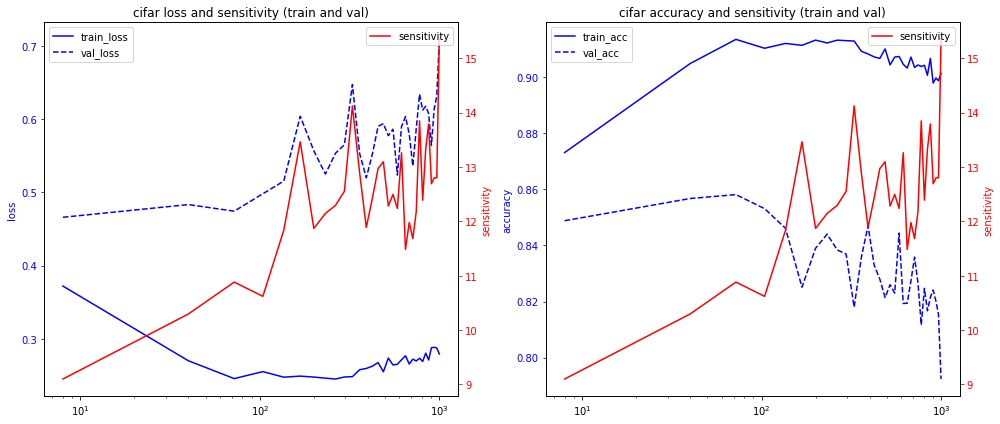

In [4]:
# 可视化结果
# ----读入数据----
logger = torch.load(config.save_dir + '/sensitivity.pth.tar')
batch = [entry['batch'] for _, entry in logger.entries.items()]
train_loss = [entry['train_loss'] for _, entry in logger.entries.items()]
val_loss = [entry['val_loss'] for _, entry in logger.entries.items()]
train_acc = [entry['train_acc'] for _, entry in logger.entries.items()]
val_acc = [entry['val_acc'] for _, entry in logger.entries.items()]
sensitivity = [entry['sensitivity'] for _, entry in logger.entries.items()]
# ----绘图----
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_title('cifar loss and sensitivity (train and val)')
ax2.set_title('cifar accuracy and sensitivity (train and val)')
ax1.semilogx(batch, train_loss, 'b', label='train_loss')
ax1.semilogx(batch, val_loss, 'b--', label='val_loss')
ax11 = ax1.twinx()
ax11.semilogx(batch, sensitivity, 'r', label='sensitivity')
ax1.legend(loc='upper left'), ax11.legend(loc='upper right')
ax1.set_ylabel('loss', color='b'), ax11.set_ylabel('sensitivity', color='r')
ax1.tick_params('y', colors='b'), ax11.tick_params('y', colors='r')

ax2.semilogx(batch, train_acc, 'b', label='train_acc')
ax2.semilogx(batch, val_acc, 'b--', label='val_acc')
ax22 = ax2.twinx()
ax22.semilogx(batch, sensitivity, 'r', label='sensitivity')
ax2.legend(loc='upper left'), ax22.legend(loc='upper right')
ax2.set_ylabel('accuracy', color='b'), ax22.set_ylabel('sensitivity', color='r')
ax2.tick_params('y', colors='b'), ax22.tick_params('y', colors='r')

plt.tight_layout()
plt.show()

### 结果分析

1. 由于sensitivity是通过validate数据集上面进行计算的，所以主要对比它和validate loss和validate accuracy
2. 可以发现，越大的validate loss和越小的validate accuracy对应越大的sensitivity（大体上满足这一规律），因此sensitivity大体上能够反映模型的generalization能力。sensitivity越小，代表模型的泛化能力